### Built-from-Scratch Image Classification Models

In this notebook I will explore various model architectures including with varying numbers of convolutional layers, numbers of neurons in the convolutional and dense layers, different activation functions for the dense layer, different optimizers, and different learning rates. 

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [3]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

test = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


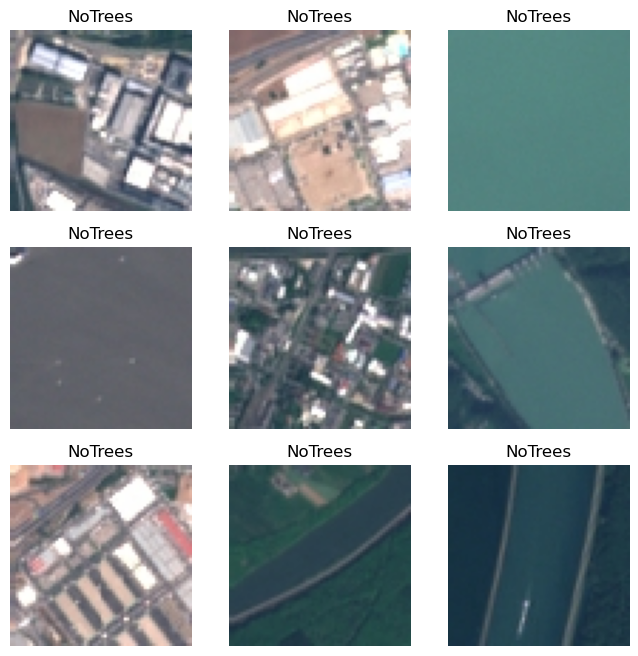

In [4]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [5]:
# build a network from scratch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model_1 = Sequential(name="model_1")
model_1.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_1.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid')) #1 for binary output


In [6]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0   

In [8]:
from time import time

In [9]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

history_model_1 = model_1.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 35s 65ms/step - loss: 0.3465 - accuracy: 0.8643 - val_loss: 0.6221 - val_accuracy: 0.6578
Epoch 2/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1907 - accuracy: 0.9244 - val_loss: 0.4856 - val_accuracy: 0.8161
Epoch 3/20
517/517 [==============================] - 36s 69ms/step - loss: 0.1580 - accuracy: 0.9407 - val_loss: 0.4761 - val_accuracy: 0.8475
Epoch 4/20
517/517 [==============================] - 37s 72ms/step - loss: 0.1127 - accuracy: 0.9591 - val_loss: 0.1765 - val_accuracy: 0.9347
Epoch 5/20
517/517 [==============================] - 35s 67ms/step - loss: 0.1177 - accuracy: 0.9558 - val_loss: 2.4430 - val_accuracy: 0.6917
Epoch 6/20
517/517 [==============================] - 35s 68ms/step - loss: 0.1222 - accuracy: 0.9527 - val_loss: 0.1960 - val_accuracy: 0.9284
Epoch 7/20
517/517 [==============================] - 31s 60ms/step - loss: 0.0664 - accuracy: 0.9744 - val_loss: 2.1848 - val_accuracy:

Now that I have a proper model run, I'll make a function to plot the learning curves:

In [10]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

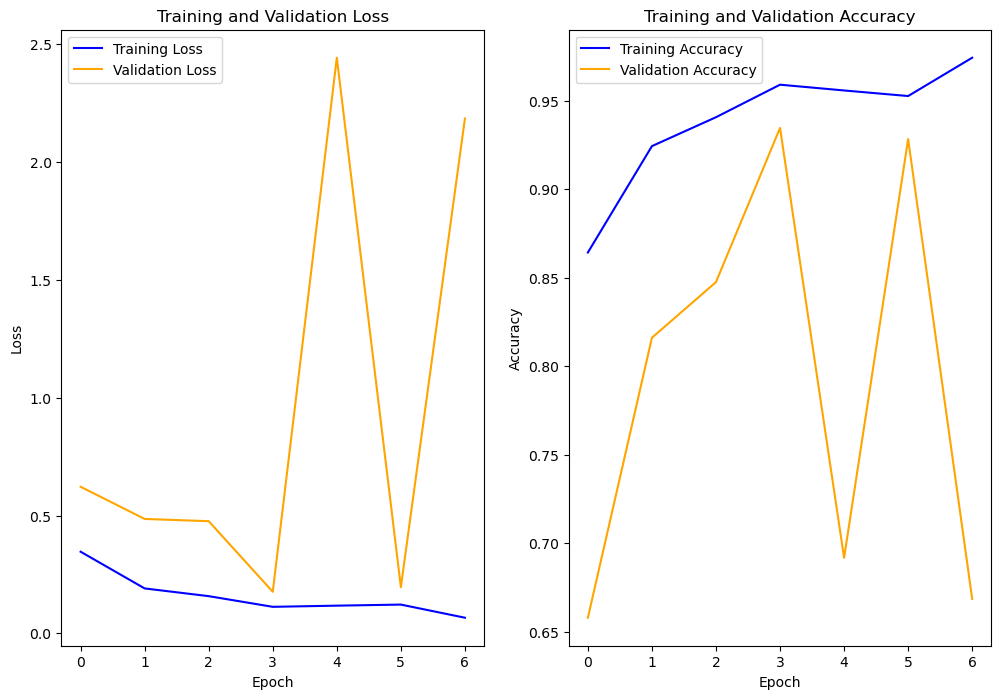

In [12]:
model_1_plots = plot_learning_curve(history_model_1)

So, it looks like improvements in the training accuracy and loss start to level off after around 10-12 epochs. The validation loss and accuracy bounce around but then appear to get worse after the 13th epoch. I will try out a slower learning rate to see if that reduces the noise in the validation learning curves and introduce early stopping:

In [13]:
#model 2
model_2 = Sequential(name="model_2")
model_2.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [14]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)
#lr_reducer = tf.keras.callbacks.LearningRateScheduler(scheduler)

start = time()

# Fit the model
history_model_2 = model_2.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 35s 65ms/step - loss: 0.3312 - accuracy: 0.8633 - val_loss: 2.9085 - val_accuracy: 0.4840
Epoch 2/20
517/517 [==============================] - 33s 64ms/step - loss: 0.2071 - accuracy: 0.9210 - val_loss: 0.4152 - val_accuracy: 0.8625
Epoch 3/20
517/517 [==============================] - 31s 60ms/step - loss: 0.1693 - accuracy: 0.9336 - val_loss: 0.5865 - val_accuracy: 0.7536
Epoch 4/20
517/517 [==============================] - 31s 60ms/step - loss: 0.1463 - accuracy: 0.9441 - val_loss: 1.1113 - val_accuracy: 0.8219
Epoch 5/20
517/517 [==============================] - 31s 61ms/step - loss: 0.1244 - accuracy: 0.9510 - val_loss: 0.2347 - val_accuracy: 0.8979
Epoch 6/20
517/517 [==============================] - 33s 63ms/step - loss: 0.1132 - accuracy: 0.9554 - val_loss: 0.1095 - val_accuracy: 0.9661
Epoch 7/20
517/517 [==============================] - 32s 62ms/step - loss: 0.0822 - accuracy: 0.9687 - val_loss: 0.2281 - val_accuracy:

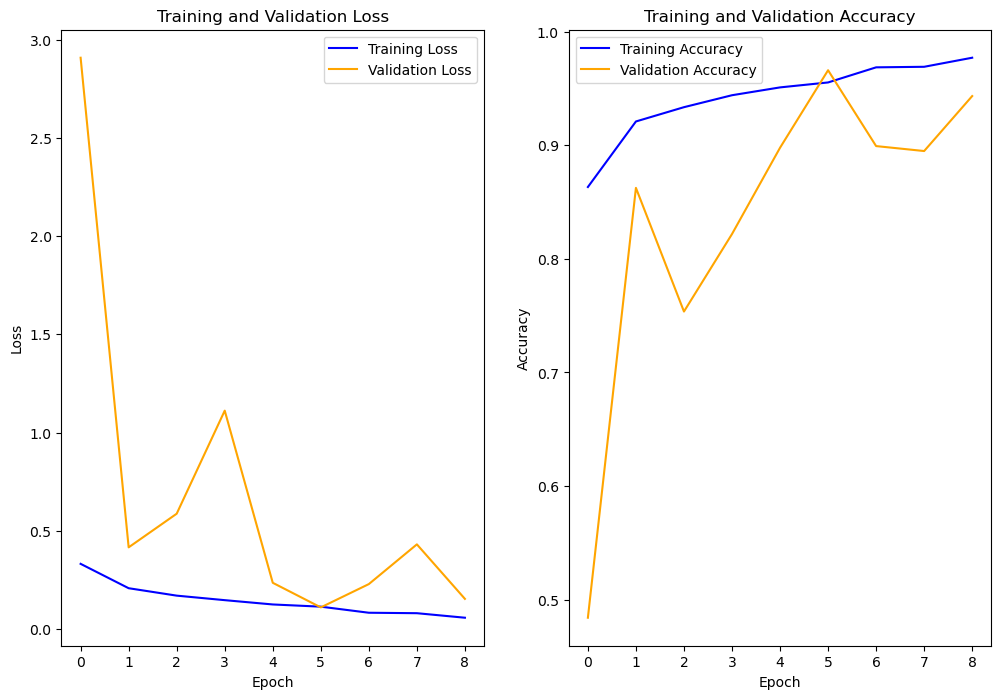

In [17]:
model_2_plots = plot_learning_curve(history_model_2)

Reducing the learning rate got rid of a lot of the jumpiness in the validation learning curves. And with the early stopping callback parameter validation accuracy hit a peak on the 3rd epoch and did not improve past that mark after three more epochs and so training stopped. 
The next network below will add more neurons to the convolutional and dense layers

In [18]:
#let's try the same model architecture as model_2 but with a slightly slower learning rate
model_2a = Sequential(name="model_2a")
model_2a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2a.add(MaxPool2D())
model_2a.add(BatchNormalization())
model_2a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2a.add(MaxPool2D())
model_2a.add(BatchNormalization())
model_2a.add(Flatten())
model_2a.add(Dense(64, activation='relu'))
model_2a.add(Dense(1, activation='sigmoid'))

model_2a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
start = time()

# Fit the model
history_model_2a = model_2a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 35s 64ms/step - loss: 0.3006 - accuracy: 0.8864 - val_loss: 0.2362 - val_accuracy: 0.9042
Epoch 2/20
517/517 [==============================] - 33s 63ms/step - loss: 0.1616 - accuracy: 0.9390 - val_loss: 0.4614 - val_accuracy: 0.8500
Epoch 3/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1302 - accuracy: 0.9510 - val_loss: 0.3381 - val_accuracy: 0.8901
Epoch 4/20
517/517 [==============================] - 32s 63ms/step - loss: 0.0979 - accuracy: 0.9620 - val_loss: 0.1120 - val_accuracy: 0.9598
Epoch 5/20
517/517 [==============================] - 33s 64ms/step - loss: 0.1170 - accuracy: 0.9548 - val_loss: 0.0881 - val_accuracy: 0.9700
Epoch 6/20
517/517 [==============================] - 33s 64ms/step - loss: 0.0796 - accuracy: 0.9693 - val_loss: 0.1272 - val_accuracy: 0.9506
Epoch 7/20
517/517 [==============================] - 33s 63ms/step - loss: 0.0910 - accuracy: 0.9647 - val_loss: 0.3436 - val_accuracy:

In [20]:
#model 3
model_3 = Sequential(name="model_3")
model_3.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_3.add(Conv2D(24, kernel_size=3, padding='same', activation = 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Conv2D(48, kernel_size=3, padding='same', activation= 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(96, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 24)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 24)       96        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 48)       0   

In [21]:
start = time()

# Fit the model
history_model_3 = model_3.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 46s 86ms/step - loss: 0.3531 - accuracy: 0.8816 - val_loss: 1.7526 - val_accuracy: 0.5165
Epoch 2/20
517/517 [==============================] - 44s 86ms/step - loss: 0.1967 - accuracy: 0.9225 - val_loss: 0.1513 - val_accuracy: 0.9405
Epoch 3/20
517/517 [==============================] - 44s 86ms/step - loss: 0.1449 - accuracy: 0.9451 - val_loss: 0.2475 - val_accuracy: 0.8925
Epoch 4/20
517/517 [==============================] - 45s 87ms/step - loss: 0.1155 - accuracy: 0.9551 - val_loss: 0.4398 - val_accuracy: 0.8320
Epoch 5/20
517/517 [==============================] - 45s 87ms/step - loss: 0.1050 - accuracy: 0.9597 - val_loss: 0.2554 - val_accuracy: 0.8935
Elapsed Time = 224.69978046417236 seconds


So with this network with more neurons, validation accuracy and loss are very volatile again, even with the reduced learning rate. 

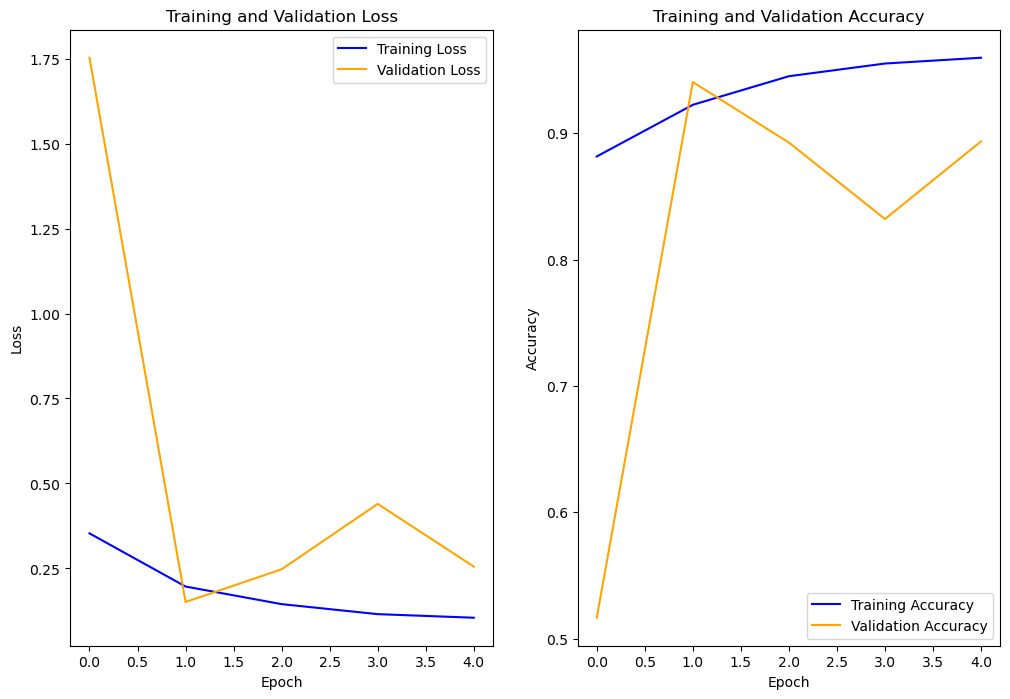

In [22]:
model_3_plots = plot_learning_curve(history_model_3)

I'll now try a model similar to model 2 with the original numebr of neurons, but with sigmoid instead of relu activation functions for the convolutional layers:

In [23]:
#model 4
model_4 = Sequential(name="model_4")
model_4.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Flatten())
model_4.add(Dense(64, activation='sigmoid'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0   

In [24]:
# we'll do early stopping again
start = time()

# Fit the model
history_model_4 = model_4.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 36s 67ms/step - loss: 0.3866 - accuracy: 0.8266 - val_loss: 0.4136 - val_accuracy: 0.8064
Epoch 2/20
517/517 [==============================] - 34s 66ms/step - loss: 0.2918 - accuracy: 0.8766 - val_loss: 0.4171 - val_accuracy: 0.8107
Epoch 3/20
517/517 [==============================] - 35s 67ms/step - loss: 0.2427 - accuracy: 0.9078 - val_loss: 0.2516 - val_accuracy: 0.9032
Epoch 4/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1950 - accuracy: 0.9258 - val_loss: 0.2304 - val_accuracy: 0.9042
Epoch 5/20
517/517 [==============================] - 37s 71ms/step - loss: 0.1626 - accuracy: 0.9411 - val_loss: 0.2415 - val_accuracy: 0.8829
Epoch 6/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1281 - accuracy: 0.9544 - val_loss: 0.1787 - val_accuracy: 0.9308
Epoch 7/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1185 - accuracy: 0.9596 - val_loss: 0.1291 - val_accuracy:

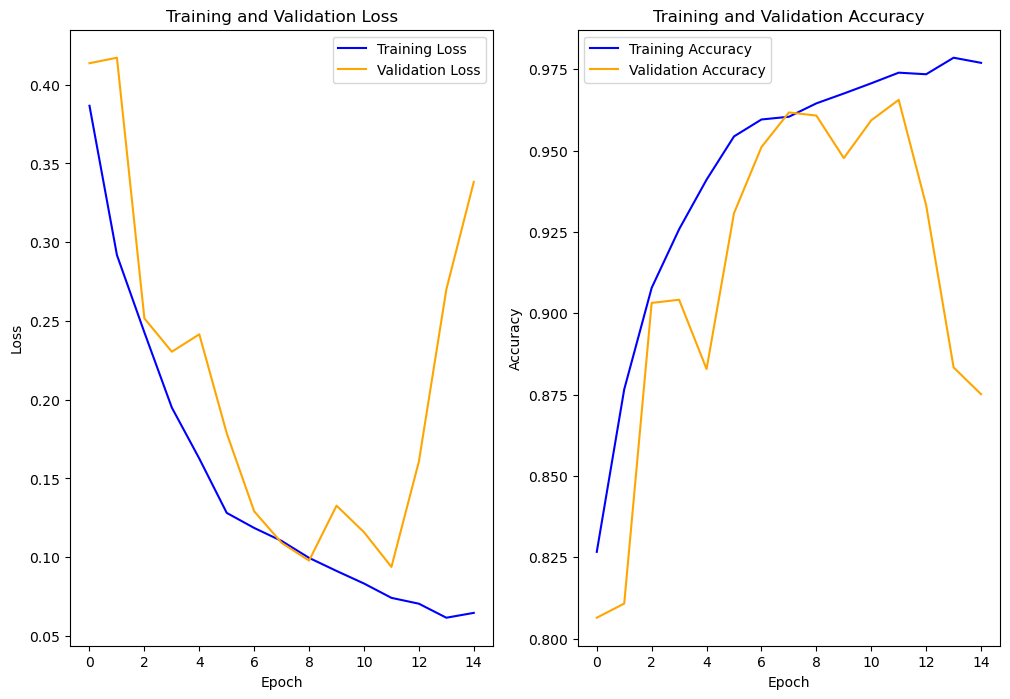

In [25]:
model_4_plots = plot_learning_curve(history_model_4)

With sigmoid activation functions in the convolutional layers, the network hits peak validation accuracy after the 9th epoch and stops early after the 12th when validation accuracy does not improve further.

In [26]:
max(history_model_4.history['val_accuracy'])

0.9656340479850769

In [27]:
max(history_model_3.history['val_accuracy'])

0.9404646754264832

So the network with two convolutional layers and one dense layer all using the relu activation function performed better than the one with sigmoid activation functions. And the validation loss and accuracy are still very volatile even with the reduced learning rate. I could try reducing it further. And after that, I will try an additional convolutional layer, using relu activation again.

In [28]:
model_4a = Sequential(name="model_4a")
model_4a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Flatten())
model_4a.add(Dense(64, activation='sigmoid'))
model_4a.add(Dense(1, activation='sigmoid'))

model_4a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
start = time()

# Fit the model
history_model_4a = model_4a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 35s 66ms/step - loss: 0.4050 - accuracy: 0.8060 - val_loss: 0.4560 - val_accuracy: 0.8180
Epoch 2/20
517/517 [==============================] - 34s 66ms/step - loss: 0.2897 - accuracy: 0.8816 - val_loss: 0.3500 - val_accuracy: 0.8500
Epoch 3/20
517/517 [==============================] - 34s 66ms/step - loss: 0.2633 - accuracy: 0.8941 - val_loss: 0.2859 - val_accuracy: 0.8829
Epoch 4/20
517/517 [==============================] - 30s 58ms/step - loss: 0.2147 - accuracy: 0.9200 - val_loss: 0.3149 - val_accuracy: 0.8659
Epoch 5/20
517/517 [==============================] - 30s 57ms/step - loss: 0.1629 - accuracy: 0.9434 - val_loss: 0.3228 - val_accuracy: 0.8267
Epoch 6/20
517/517 [==============================] - 29s 57ms/step - loss: 0.1391 - accuracy: 0.9531 - val_loss: 0.1687 - val_accuracy: 0.9342
Epoch 7/20
517/517 [==============================] - 30s 58ms/step - loss: 0.1152 - accuracy: 0.9601 - val_loss: 0.1013 - val_accuracy:

In [30]:
#model 5
model_5 = Sequential(name="model_5")
model_5.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 32)       0   

In [31]:
start = time()

# Fit the model
history_model_5 = model_5.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 37s 69ms/step - loss: 0.3221 - accuracy: 0.8706 - val_loss: 0.4578 - val_accuracy: 0.8311
Epoch 2/20
517/517 [==============================] - 36s 69ms/step - loss: 0.1879 - accuracy: 0.9264 - val_loss: 0.8934 - val_accuracy: 0.6602
Epoch 3/20
517/517 [==============================] - 35s 68ms/step - loss: 0.1562 - accuracy: 0.9382 - val_loss: 0.1873 - val_accuracy: 0.9172
Epoch 4/20
517/517 [==============================] - 35s 68ms/step - loss: 0.1052 - accuracy: 0.9577 - val_loss: 0.1285 - val_accuracy: 0.9424
Epoch 5/20
517/517 [==============================] - 35s 68ms/step - loss: 0.0787 - accuracy: 0.9698 - val_loss: 0.4213 - val_accuracy: 0.8470
Epoch 6/20
517/517 [==============================] - 36s 70ms/step - loss: 0.0935 - accuracy: 0.9639 - val_loss: 1.3905 - val_accuracy: 0.6505
Epoch 7/20
517/517 [==============================] - 36s 70ms/step - loss: 0.0696 - accuracy: 0.9735 - val_loss: 0.7054 - val_accuracy:

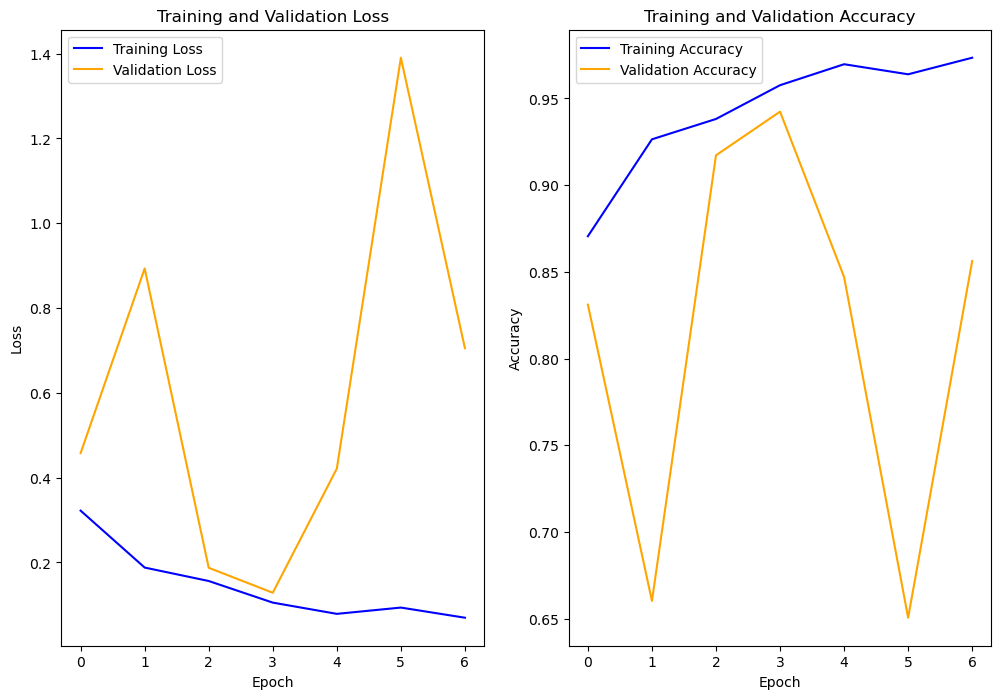

In [32]:
model_5_plots = plot_learning_curve(history_model_5)

I'll try a model similar to 5, but with SGD optimizer instead of adam

In [33]:
#model 5a
model_5a = Sequential(name="model_5a")
model_5a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(Flatten())
model_5a.add(Dense(64, activation='relu'))
model_5a.add(Dense(1, activation='sigmoid'))

model_5a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])


In [34]:
start = time()

# Fit the model
history_model_5a = model_5a.fit(training, validation_data=test, epochs=12)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/12
517/517 [==============================] - 32s 60ms/step - loss: 0.3774 - accuracy: 0.8360 - val_loss: 0.5329 - val_accuracy: 0.6897
Epoch 2/12
517/517 [==============================] - 31s 59ms/step - loss: 0.2743 - accuracy: 0.8911 - val_loss: 0.2319 - val_accuracy: 0.9080
Epoch 3/12
517/517 [==============================] - 31s 59ms/step - loss: 0.2345 - accuracy: 0.9066 - val_loss: 0.1987 - val_accuracy: 0.9284
Epoch 4/12
517/517 [==============================] - 31s 59ms/step - loss: 0.2134 - accuracy: 0.9181 - val_loss: 0.2175 - val_accuracy: 0.9134
Epoch 5/12
517/517 [==============================] - 31s 60ms/step - loss: 0.1918 - accuracy: 0.9262 - val_loss: 0.1998 - val_accuracy: 0.9216
Epoch 6/12
517/517 [==============================] - 31s 59ms/step - loss: 0.1807 - accuracy: 0.9310 - val_loss: 0.2096 - val_accuracy: 0.9240
Epoch 7/12
517/517 [==============================] - 31s 59ms/step - loss: 0.1689 - accuracy: 0.9352 - val_loss: 0.2843 - val_accuracy:

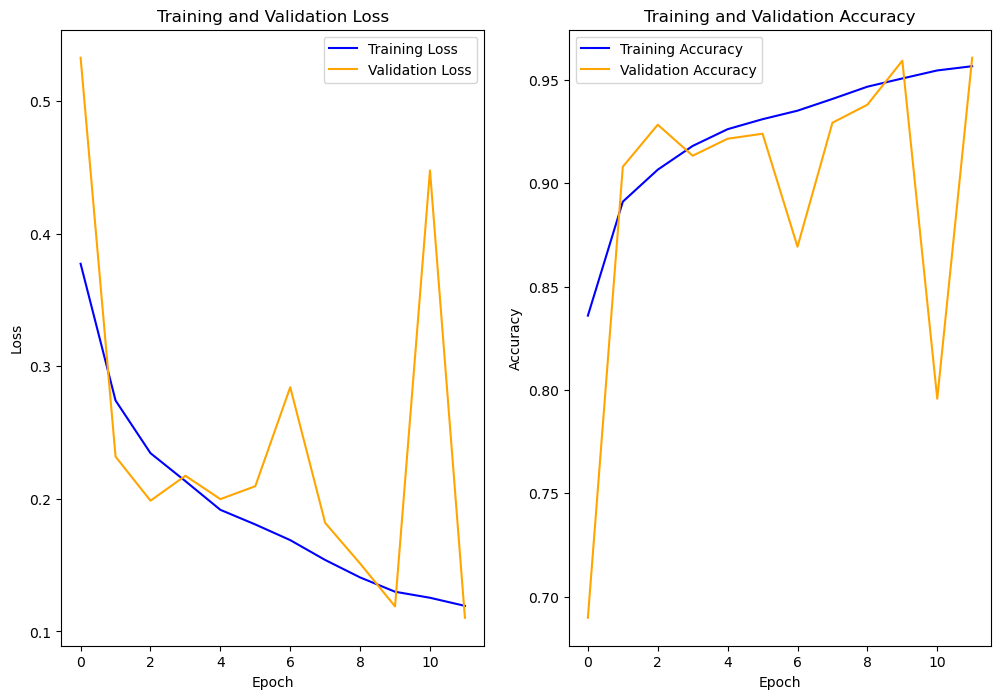

In [35]:
model_5a_plots = plot_learning_curve(history_model_5a)

I also wanted totry out an even simpler model than the first one, with only one convolutional layer:

In [36]:
model_0 = Sequential(name="model_0")
model_0.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0.add(MaxPool2D())
model_0.add(BatchNormalization())
model_0.add(Flatten())
model_0.add(Dense(32, activation='relu'))
model_0.add(Dense(1, activation='sigmoid'))

In [37]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_8 (Flatten)         (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                5243

In [38]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0 = model_0.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 20s 37ms/step - loss: 0.3488 - accuracy: 0.8598 - val_loss: 0.2721 - val_accuracy: 0.8809
Epoch 2/20
517/517 [==============================] - 19s 37ms/step - loss: 0.2511 - accuracy: 0.8910 - val_loss: 0.2396 - val_accuracy: 0.8984
Epoch 3/20
517/517 [==============================] - 19s 37ms/step - loss: 0.2101 - accuracy: 0.9105 - val_loss: 0.3308 - val_accuracy: 0.9071
Epoch 4/20
517/517 [==============================] - 19s 37ms/step - loss: 0.1914 - accuracy: 0.9243 - val_loss: 0.2837 - val_accuracy: 0.8630
Epoch 5/20
517/517 [==============================] - 19s 37ms/step - loss: 0.1497 - accuracy: 0.9398 - val_loss: 0.5924 - val_accuracy: 0.7425
Elapsed Time = 96.13827514648438 seconds


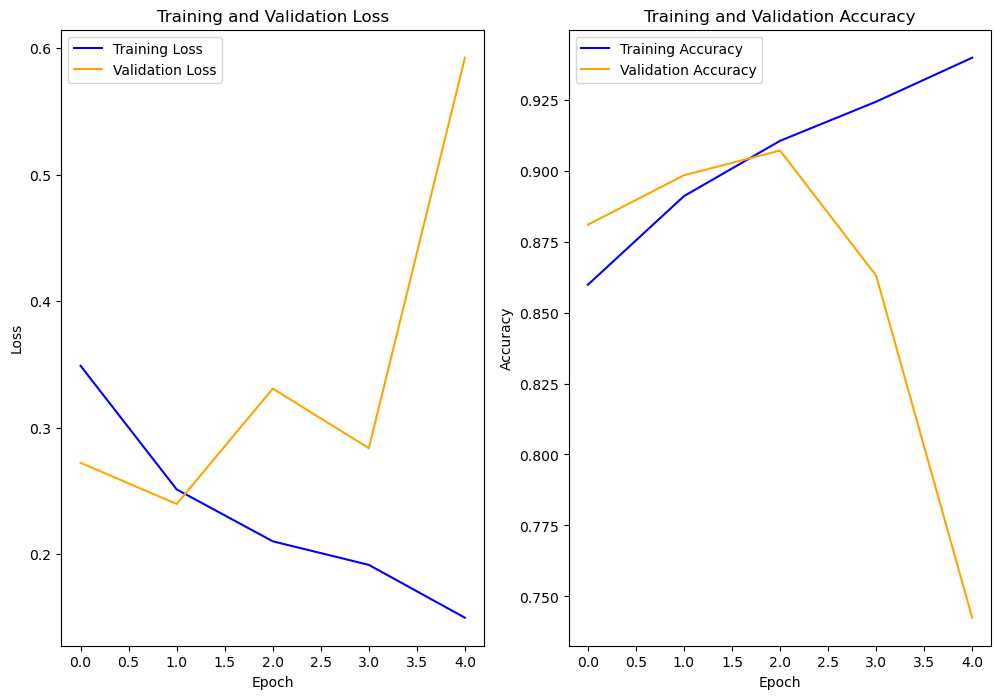

In [39]:
model_0_plots = plot_learning_curve(history_model_0)

Again, very volatile validation learning curves. I will try the same simle network with an even slower learning rate:

In [40]:
model_0a = Sequential(name="model_0a")
model_0a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0a.add(MaxPool2D())
model_0a.add(BatchNormalization())
model_0a.add(Flatten())
model_0a.add(Dense(32, activation='relu'))
model_0a.add(Dense(1, activation='sigmoid'))

In [41]:
model_0a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model_0a.summary()

Model: "model_0a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_9 (Flatten)         (None, 16384)             0         
                                                                 
 dense_18 (Dense)            (None, 32)                524

In [42]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0a = model_0a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 20s 38ms/step - loss: 0.3334 - accuracy: 0.8581 - val_loss: 0.2612 - val_accuracy: 0.8979
Epoch 2/20
517/517 [==============================] - 19s 37ms/step - loss: 0.2324 - accuracy: 0.9033 - val_loss: 0.2622 - val_accuracy: 0.8858
Epoch 3/20
517/517 [==============================] - 19s 36ms/step - loss: 0.1910 - accuracy: 0.9215 - val_loss: 0.2145 - val_accuracy: 0.9085
Epoch 4/20
517/517 [==============================] - 19s 37ms/step - loss: 0.1748 - accuracy: 0.9295 - val_loss: 0.9535 - val_accuracy: 0.7764
Epoch 5/20
517/517 [==============================] - 19s 37ms/step - loss: 0.1525 - accuracy: 0.9365 - val_loss: 0.2218 - val_accuracy: 0.9061
Epoch 6/20
517/517 [==============================] - 19s 36ms/step - loss: 0.1422 - accuracy: 0.9428 - val_loss: 0.1789 - val_accuracy: 0.9313
Epoch 7/20
517/517 [==============================] - 19s 37ms/step - loss: 0.1251 - accuracy: 0.9509 - val_loss: 0.1716 - val_accuracy:

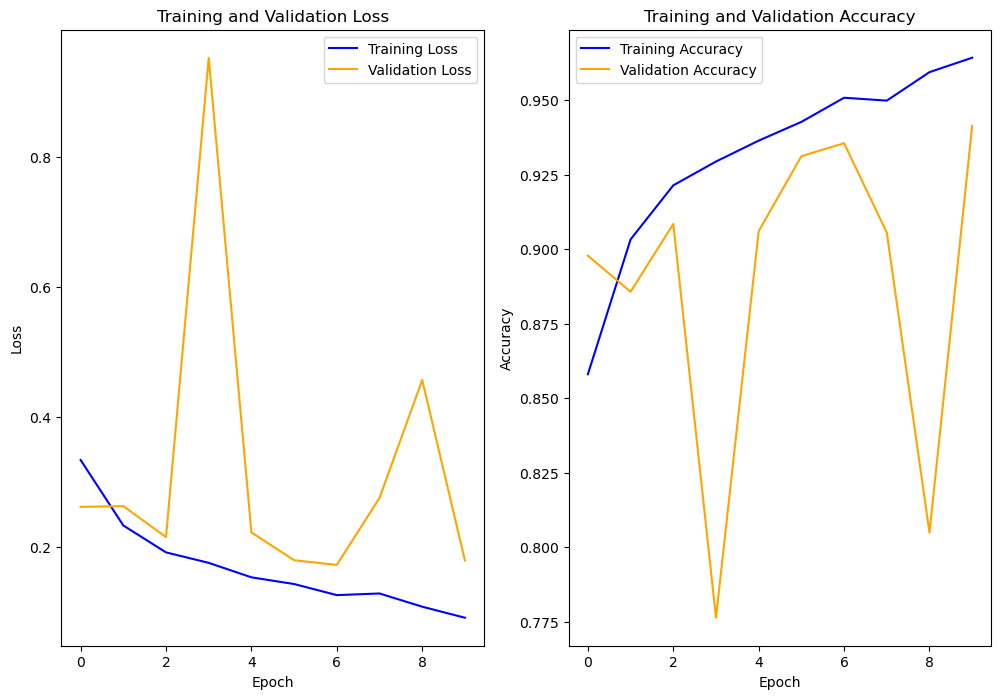

In [43]:
model_0a_plots = plot_learning_curve(history_model_0a)

Now I'll try the same but with SGD as the optimizer:

In [44]:
model_0b = Sequential(name="model_0b")
model_0b.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0b.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0b.add(MaxPool2D())
model_0b.add(BatchNormalization())
model_0b.add(Flatten())
model_0b.add(Dense(32, activation='relu'))
model_0b.add(Dense(1, activation='sigmoid'))

In [45]:
model_0b.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model_0b.summary()

Model: "model_0b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_10 (Flatten)        (None, 16384)             0         
                                                                 
 dense_20 (Dense)            (None, 32)                524

In [46]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0b = model_0b.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 18s 33ms/step - loss: 0.4436 - accuracy: 0.7919 - val_loss: 0.4463 - val_accuracy: 0.7933
Epoch 2/20
517/517 [==============================] - 17s 33ms/step - loss: 0.3764 - accuracy: 0.8439 - val_loss: 0.3599 - val_accuracy: 0.8722
Epoch 3/20
517/517 [==============================] - 17s 33ms/step - loss: 0.3531 - accuracy: 0.8539 - val_loss: 0.3370 - val_accuracy: 0.8800
Epoch 4/20
517/517 [==============================] - 17s 33ms/step - loss: 0.3268 - accuracy: 0.8650 - val_loss: 0.3442 - val_accuracy: 0.8596
Epoch 5/20
517/517 [==============================] - 17s 33ms/step - loss: 0.3082 - accuracy: 0.8761 - val_loss: 0.3126 - val_accuracy: 0.8795
Epoch 6/20
517/517 [==============================] - 17s 33ms/step - loss: 0.2972 - accuracy: 0.8818 - val_loss: 0.3001 - val_accuracy: 0.8877
Epoch 7/20
517/517 [==============================] - 17s 32ms/step - loss: 0.2862 - accuracy: 0.8865 - val_loss: 0.2981 - val_accuracy:

So the simple model does noticeably worse with the SGD optimizer. 

In [47]:
models = [model_1, model_2, model_2a, model_3, model_4, model_4a, 
             model_5, model_5a, model_0, model_0a, model_0b]
histories = [history_model_1, history_model_2, history_model_2a, history_model_3, history_model_4, history_model_4a, 
             history_model_5, history_model_5a, history_model_0, history_model_0a, history_model_0b]
print("Maximum validation accuracy achieved in for each model:")
for mod, hist in zip(models,histories):
    print(mod.name, round(max(hist.history['val_accuracy']),3))

Maximum validation accuracy achieved in for each model:
model_1 0.935
model_2 0.966
model_2a 0.97
model_3 0.94
model_4 0.966
model_4a 0.97
model_5 0.942
model_5a 0.961
model_0 0.907
model_0a 0.941
model_0b 0.894


So after reviewing these results, models 1,4,4a, and 0a have the highest validation accuracies, but these all have very volatile learning curves. The highest accuracy model with a relatively smooth learning curve is model 2 (which is also the best model with the larger validation set size). However, model 2 achieved its best validation accuracy on the 3rd epoch and only trained for 6 total epochs. Let's repeat training on model 2 below and allow it to go for 10-15 epcohs to see what the results look like:

In [48]:
model_2b = Sequential(name="model_2a")
model_2b.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2b.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2b.add(MaxPool2D())
model_2b.add(BatchNormalization())
model_2b.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2b.add(MaxPool2D())
model_2b.add(BatchNormalization())
model_2b.add(Flatten())
model_2b.add(Dense(64, activation='relu'))
model_2b.add(Dense(1, activation='sigmoid'))

model_2b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), 
                loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
start = time()

# Fit the model
history_model_2b = model_2b.fit(training, validation_data=test, epochs=12)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/12
517/517 [==============================] - 28s 52ms/step - loss: 0.3164 - accuracy: 0.8806 - val_loss: 0.6946 - val_accuracy: 0.7502
Epoch 2/12
517/517 [==============================] - 27s 53ms/step - loss: 0.1817 - accuracy: 0.9280 - val_loss: 0.3579 - val_accuracy: 0.8354
Epoch 3/12
517/517 [==============================] - 28s 53ms/step - loss: 0.1224 - accuracy: 0.9529 - val_loss: 0.2198 - val_accuracy: 0.9080
Epoch 4/12
517/517 [==============================] - 29s 57ms/step - loss: 0.1259 - accuracy: 0.9532 - val_loss: 0.1564 - val_accuracy: 0.9385
Epoch 5/12
517/517 [==============================] - 30s 58ms/step - loss: 0.1185 - accuracy: 0.9567 - val_loss: 0.3806 - val_accuracy: 0.8538
Epoch 6/12
517/517 [==============================] - 54s 105ms/step - loss: 0.0994 - accuracy: 0.9644 - val_loss: 0.5669 - val_accuracy: 0.8127
Epoch 7/12
517/517 [==============================] - 28s 54ms/step - loss: 0.0759 - accuracy: 0.9718 - val_loss: 0.1380 - val_accuracy

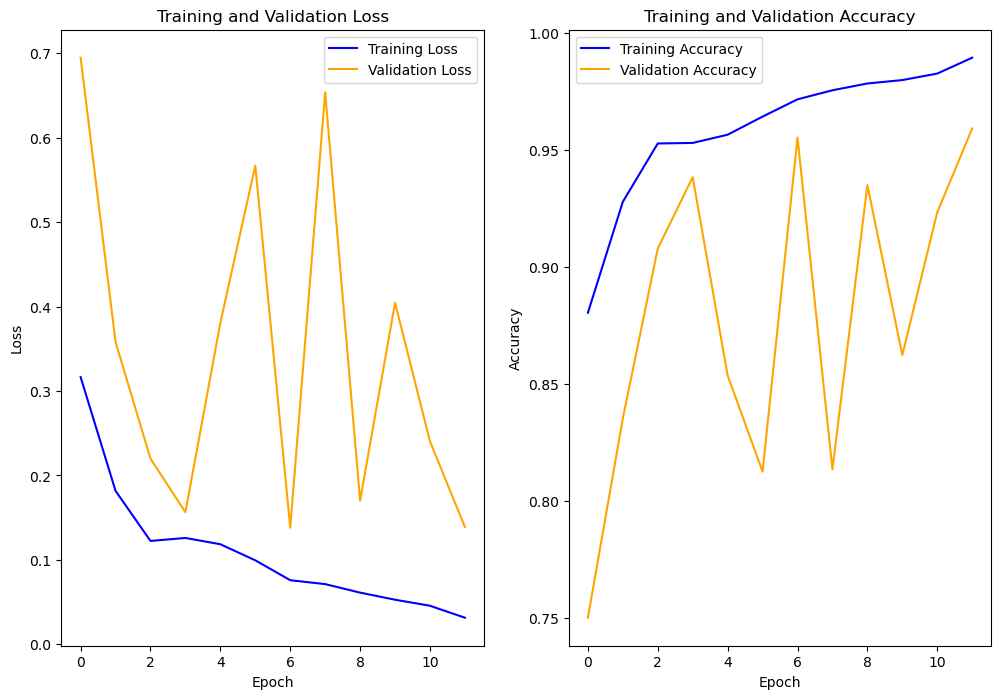

In [50]:
model_2b_plots = plot_learning_curve(history_model_2b)

Hmm, curiously, after allowing the model to run for more epochs, there is volatility present in the early epochs that was not present when early stopping was implemented...
Nonetheless, with the best model architecture selected, I will try image augmentation preprocessing to see how that affects the model:
### Image Augmentation:

In [51]:
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                     layers.RandomRotation(0.1),])

In [52]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #to suppress to verbose warnings

augmented_training_ds = training.map(lambda img, label: (image_augmentation(img), label))

In [53]:
#model 2 with augmented training set
model_2_aug = Sequential(name="model_2_with_augmented_training_set")
model_2_aug.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2_aug.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2_aug.add(MaxPool2D())
model_2_aug.add(BatchNormalization())
model_2_aug.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2_aug.add(MaxPool2D())
model_2_aug.add(BatchNormalization())
model_2_aug.add(Flatten())
model_2_aug.add(Dense(64, activation='relu'))
model_2_aug.add(Dense(1, activation='sigmoid'))

model_2_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), 
                loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
start = time()

# Fit the model
history_model_2_aug = model_2_aug.fit(augmented_training_ds, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 31s 58ms/step - loss: 0.3350 - accuracy: 0.8744 - val_loss: 1.6437 - val_accuracy: 0.4913
Epoch 2/20
517/517 [==============================] - 30s 58ms/step - loss: 0.2264 - accuracy: 0.9096 - val_loss: 0.2452 - val_accuracy: 0.9119
Epoch 3/20
517/517 [==============================] - 30s 58ms/step - loss: 0.1914 - accuracy: 0.9252 - val_loss: 0.5386 - val_accuracy: 0.8538
Epoch 4/20
517/517 [==============================] - 31s 59ms/step - loss: 0.1729 - accuracy: 0.9355 - val_loss: 0.3581 - val_accuracy: 0.8640
Epoch 5/20
517/517 [==============================] - 30s 58ms/step - loss: 0.1576 - accuracy: 0.9389 - val_loss: 2.2570 - val_accuracy: 0.5915
Elapsed Time = 153.50769329071045 seconds


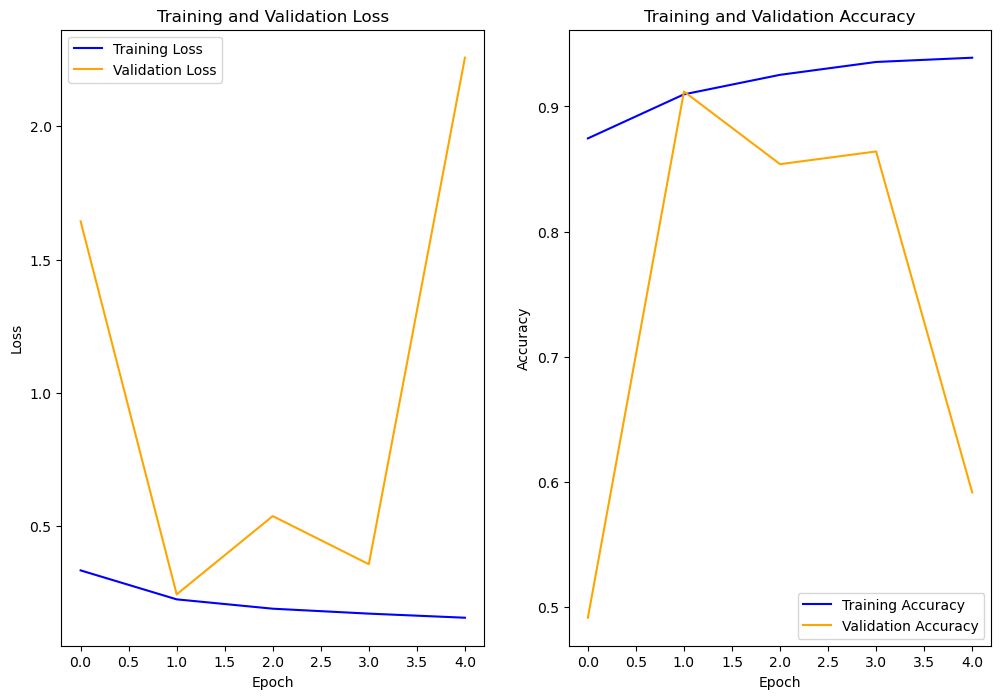

In [55]:
model_2_aug_plots = plot_learning_curve(history_model_2_aug)

As with the larger validation set, image augmentation actually reduced model performance based on both training and validation accuracy.